# **GRUPO 1** - Trabajo Práctico Nuestras Caras

## **Preparar el entorno en Google Colab**

In [1]:
# conexion al Google Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

## **Cargar las librerias que vamos a utilizar**

In [2]:
# instalo  itables solo si no esta instalado
!pip show itables >/dev/null || pip install itables

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.3 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 6.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/12.6 MB 6.8 MB/s eta 0:00:02
   --------- ------------------------------ 2.9/12.6 MB 7.0 MB/s eta 0:00:02
   -------------- ------------------------- 4.5/12.6 MB 7.2 MB/s eta 0:00:02
   ------------------ --------------------- 5.8/12.6 MB 7.1 MB/s eta 0:00:01
   ----------------------- ---------------- 7.3/12.6 MB 7.1 MB/s eta 0:00:01
   ---------------------------- ----------- 8.9/12.6 MB 7.2 MB/s eta 0:00:01
   -------------------------------- ------- 10.2/12.6 MB 7.2 MB/s eta 0:00:01
   ------------------------------------- -- 11.8/12.6 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 7.0 MB/s eta 0:00:00
   ----------

El sistema no puede encontrar la ruta especificada.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import polars as pl
import numpy as np
import math
from typing import Optional, Tuple, Dict, List
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from IPython import display
import time
import os
import pickle
from functools import reduce
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import cv2
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelBinarizer

AttributeError: partially initialized module 'polars' from 'c:\Users\Guadalupe\AppData\Local\Programs\Python\Python313\Lib\site-packages\polars\__init__.py' has no attribute '_cpu_check' (most likely due to a circular import)

## **Cargar modelo DNN para la detección de caras**

In [ ]:
# Cargar el modelo DNN para detección de caras
MODELO_DIR = "/content/drive/MyDrive/DMA_Eigenfaces"
PROTOTXT_PATH = os.path.join(MODELO_DIR, "deploy.prototxt")
CAFFEMODEL_PATH = os.path.join(MODELO_DIR, "res10_300x300_ssd_iter_140000.caffemodel")

def verificar_y_descargar_modelos():
    os.makedirs(MODELO_DIR, exist_ok=True)
    if not os.path.exists(PROTOTXT_PATH):
        !wget -q -O "{PROTOTXT_PATH}" https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
    if not os.path.exists(CAFFEMODEL_PATH):
        !wget -q -O "{CAFFEMODEL_PATH}" https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

def cargar_face_detector() -> cv2.dnn_Net:
    verificar_y_descargar_modelos()
    net = cv2.dnn.readNetFromCaffe(PROTOTXT_PATH, CAFFEMODEL_PATH)
    return net

## **Función para detectar los rostros**

In [ ]:
def detectar_cara_dnn(img: np.ndarray, net: cv2.dnn_Net, confidence_threshold: float) -> Optional[Tuple[int, int, int, int]]:
    """
    Detecta una cara y devuelve las coordenadas de la mejor detección como (x1, y1, x2, y2).
    No realiza recortes, ni cambios de color, ni resize.
    """
    if img is None:
        return None

    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    if detections.shape[2] == 0:
        return None

    best_conf, best_box = 0, None
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if conf > best_conf and conf > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            best_box = box.astype("int")
            best_conf = conf

    if best_box is None:
        return None

    x1, y1, x2, y2 = best_box
    return (x1, y1, x2, y2)


## **Función para procesar las imagenes y guardarlas redimensionadas en disco.**

In [ ]:
def procesar_y_crear_dataset(
    input_folder: str,
    output_folder: str,
    sin_caras_folder: Optional[str],
    pickle_path: Optional[str],
    net: cv2.dnn_Net,
    img_size: Tuple[int, int] = (64, 64),
    confidence_threshold: float = 0.3
) -> pl.DataFrame:
    """
    Procesa imágenes: detecta caras, recorta, convierte a gris, resizea, guarda en disco y crea un DataFrame Polars.
    Opcionalmente, guarda el DataFrame en un archivo Pickle.

    Args:
        input_folder: Carpeta con subcarpetas de imágenes etiquetadas.
        output_folder: Carpeta donde se guardarán las imágenes procesadas.
        sin_caras_folder: Carpeta para imágenes sin caras detectadas (opcional).
        pickle_path: Ruta para guardar el DataFrame como archivo Pickle (opcional).
        net: Modelo DNN para detección de caras.
        img_size: Tamaño al que se redimensionan las imágenes.
        confidence_threshold: Umbral de confianza para detección de caras.

    Returns:
        Polars DataFrame con dos columnas: 'imagen' (array aplanado) y 'etiqueta' (nombre de la persona).
    """
    imagenes = []
    etiquetas = []

    for subdir, _, files in os.walk(input_folder):
        etiqueta = os.path.basename(subdir)
        if subdir == input_folder:
            continue

        output_subdir = os.path.join(output_folder, etiqueta)
        os.makedirs(output_subdir, exist_ok=True)

        for file in files:
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            input_path = os.path.join(subdir, file)
            img = cv2.imread(input_path)

            if img is None:
                continue

            box = detectar_cara_dnn(img, net, confidence_threshold)
            if box is not None:
                x1, y1, x2, y2 = box

                # Añadir margen
                margin_ratio = 0.2
                bw, bh = x2 - x1, y2 - y1
                x1 = max(0, x1 - int(bw * margin_ratio))
                y1 = max(0, y1 - int(bh * margin_ratio))
                x2 = min(img.shape[1], x2 + int(bw * margin_ratio))
                y2 = min(img.shape[0], y2 + int(bh * margin_ratio))

                face_crop = img[y1:y2, x1:x2]
                face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
                face_crop = cv2.resize(face_crop, img_size)

                # Guardar imagen procesada
                output_path = os.path.join(output_subdir, file)
                cv2.imwrite(output_path, face_crop)

                # Aplanar imagen para el DataFrame
                img_flat = face_crop.flatten()
                imagenes.append(img_flat)
                etiquetas.append(etiqueta)

            else:
                if sin_caras_folder:
                    os.makedirs(sin_caras_folder, exist_ok=True)
                    cv2.imwrite(os.path.join(sin_caras_folder, file), img)

    df = pl.DataFrame({
        "imagen": imagenes,
        "etiqueta": etiquetas
    })

    # Guardar DataFrame como Pickle si se especifica pickle_path
    if pickle_path:
        os.makedirs(os.path.dirname(pickle_path) or '.', exist_ok=True)
        with open(pickle_path, 'wb') as f:
            pickle.dump(df, f)

    return df

## ** Definición de carpetas origen y destino y carga de modelos para detección de caras.

In [ ]:
net = cargar_face_detector()  # Esto automáticamente verifica/descarga/carga ✅

# 1. Definir carpetas
input_folder = "/content/drive/MyDrive/DMA_Eigenfaces/Eigenfaces"
output_folder = "/content/drive/MyDrive/DMA_Eigenfaces/Caras_Procesadas_DNN"
sin_caras_folder = "/content/drive/MyDrive/DMA_Eigenfaces/Sin_Caras_DNN"
pickle_path = "/content/drive/MyDrive/DMA_Eigenfaces/df_caras"


## **Procesamos las imágenes y guardamos en output_folder**

In [ ]:
# Procesar imágenes y obtener DataFrame
df = procesar_y_crear_dataset(
    input_folder,
    output_folder,
    sin_caras_folder,
    pickle_path,
    net=net,
    img_size=(64, 64),
    confidence_threshold=0.3
)

shape: (5, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ x1        ┆ x2        ┆ x3        ┆ x4        ┆ … ┆ y_Maurici ┆ y_Natalia ┆ y_NoeliaM ┆ y_Noelia │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ o         ┆ ---       ┆ ---       ┆ R        │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ i64       ┆ i64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ i64       ┆           ┆           ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 6212.9518 ┆ -910.5789 ┆ -564.1508 ┆ 2112.5240 ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0        │
│ 56        ┆ 21        ┆ 63        ┆ 24        ┆   ┆           ┆           ┆           ┆          │
│ -4079.621 ┆ 4848.1566 ┆ 383.27619 ┆ 2031.9291 ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0        │
│ 47        ┆ 76        ┆           ┆ 16        ┆   ┆           ┆           

## **Cargar el dataset guardado**

In [ ]:
# Cargar el DataFrame desde el archivo Pickle
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

In [ ]:
print(df.head())

shape: (5, 2)
┌──────────────────┬───────────┐
│ imagen           ┆ etiqueta  │
│ ---              ┆ ---       │
│ array[u8, 4096]  ┆ str       │
╞══════════════════╪═══════════╡
│ [169, 168, … 17] ┆ Jorgelina │
│ [165, 164, … 24] ┆ Jorgelina │
│ [166, 166, … 16] ┆ Jorgelina │
│ [168, 167, … 19] ┆ Jorgelina │
│ [160, 163, … 14] ┆ Jorgelina │
└──────────────────┴───────────┘


## **Preparar dataframe para ISOMAP**

In [ ]:
# Preparar datos para ISOMAP
X = np.stack(df["imagen"].to_list())  # Matriz de características
y = df["etiqueta"].to_numpy()         # Etiquetas

## **División en train y test antes de aplicar ISOMAP**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)


## **Busqueda de mejores hiperparametros para ISOMAP**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def buscar_mejores_hiperparametros_isomap_nn(X, y, n_neighbors_prueba=[5, 10, 15, 20], componentes_prueba=[10, 20, 30, 40, 50, 100], test_size=0.2, random_state=42):
    """
    Busca los mejores n_neighbors y n_components para ISOMAP optimizando el rendimiento de una red neuronal.

    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Training data (e.g., image features).
    y : array-like, shape (n_samples,)
        Labels (person identities).
    n_neighbors_prueba : list, default=[5, 10, 15, 20]
        List of n_neighbors values to test.
    componentes_prueba : list, default=[10, 20, 50, 100]
        List of n_components values to test.
    test_size : float, default=0.2
        Proportion of data to use as validation set.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns:
    --------
    mejor_n_neighbors : int
        Best n_neighbors value.
    mejor_n_components : int
        Best n_components value.
    """
    # Input validation
    n_samples, n_features = X.shape
    max_components = min(n_samples, n_features)
    if any(n > max_components for n in componentes_prueba):
        raise ValueError(f"n_components must not exceed {max_components}")
    if any(n >= n_samples for n in n_neighbors_prueba):
        raise ValueError(f"n_neighbors must be less than {n_samples}")

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    accuracies = np.zeros((len(n_neighbors_prueba), len(componentes_prueba)))

    for i, n_neighbors in enumerate(n_neighbors_prueba):
        for j, n_components in enumerate(componentes_prueba):
            try:
                # Apply ISOMAP
                isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
                X_train_isomap = isomap.fit_transform(X_train)
                X_val_isomap = isomap.transform(X_val)

                # Train a simple neural network (MLP)
                nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=random_state)
                nn.fit(X_train_isomap, y_train)

                # Evaluate on validation set
                y_pred = nn.predict(X_val_isomap)
                accuracy = accuracy_score(y_val, y_pred)
                accuracies[i, j] = accuracy
            except Exception as e:
                print(f"Error para n_neighbors={n_neighbors}, n_components={n_components}: {e}")
                accuracies[i, j] = 0.0  # Assign low accuracy if it fails

    # Find best hyperparameters
    max_accuracy_idx = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)
    mejor_n_neighbors = n_neighbors_prueba[max_accuracy_idx[0]]
    mejor_n_components = componentes_prueba[max_accuracy_idx[1]]
    max_accuracy = accuracies[max_accuracy_idx]

    # Visualize results
    plt.figure(figsize=(10, 8))
    sns.heatmap(accuracies, xticklabels=componentes_prueba, yticklabels=n_neighbors_prueba, annot=True, fmt=".4f", cmap="viridis")
    plt.xlabel('Número de componentes (n_components)')
    plt.ylabel('Número de vecinos (n_neighbors)')
    plt.title('Precisión de validación para ISOMAP + Red Neuronal')
    plt.show()

    print(f"✅ Mejores hiperparámetros encontrados:")
    print(f"   - n_neighbors: {mejor_n_neighbors}")
    print(f"   - n_components: {mejor_n_components}")
    print(f"   - Precisión de validación: {max_accuracy:.4f}")

    return mejor_n_neighbors, mejor_n_components

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint

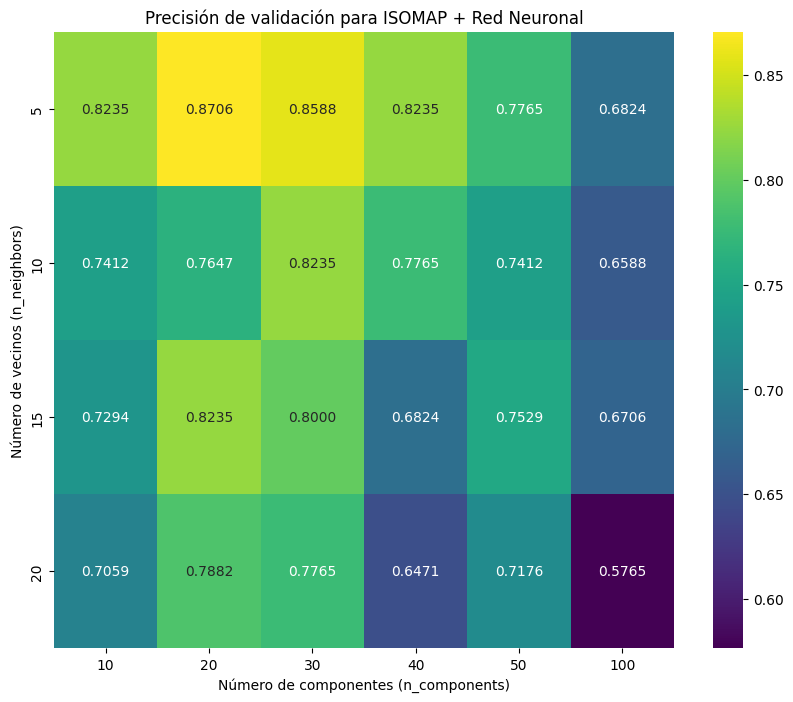

✅ Mejores hiperparámetros encontrados:
   - n_neighbors: 5
   - n_components: 20
   - Precisión de validación: 0.8706


(5, 20)

In [ ]:
buscar_mejores_hiperparametros_isomap_nn(X_train, y_train)

In [ ]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt

def analizar_conectividad_grafo(X, vecinos_prueba=[2, 3, 4, 5, 6, 7, 8, 9, 10]):
    componentes = []
    for k in vecinos_prueba:
        G = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False, n_jobs=-1)
        n_comp, _ = connected_components(G)
        print(f"Vecinos: {k} ➝ Componentes conectadas: {n_comp}")
        componentes.append(n_comp)

    plt.figure(figsize=(8,5))
    plt.plot(vecinos_prueba, componentes, marker='o')
    plt.axhline(1, color='green', linestyle='--', label='Grafo conexo')
    plt.xlabel("Número de vecinos")
    plt.ylabel("Componentes conectadas")
    plt.title("Conectividad del grafo de vecinos")
    plt.grid(True)
    plt.legend()
    plt.show()

Vecinos: 2 ➝ Componentes conectadas: 27
Vecinos: 3 ➝ Componentes conectadas: 13
Vecinos: 4 ➝ Componentes conectadas: 7
Vecinos: 5 ➝ Componentes conectadas: 3
Vecinos: 6 ➝ Componentes conectadas: 2
Vecinos: 7 ➝ Componentes conectadas: 2
Vecinos: 8 ➝ Componentes conectadas: 2
Vecinos: 9 ➝ Componentes conectadas: 1
Vecinos: 10 ➝ Componentes conectadas: 1
Vecinos: 12 ➝ Componentes conectadas: 1
Vecinos: 13 ➝ Componentes conectadas: 1
Vecinos: 14 ➝ Componentes conectadas: 1
Vecinos: 15 ➝ Componentes conectadas: 1
Vecinos: 20 ➝ Componentes conectadas: 1


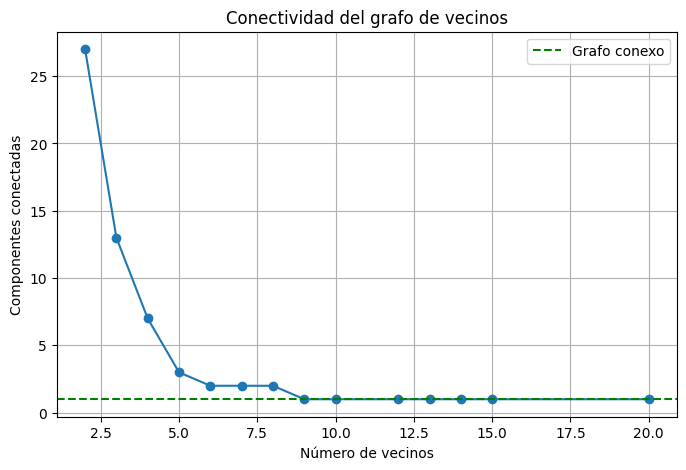

In [ ]:
analizar_conectividad_grafo(X_train, vecinos_prueba=[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 20])

In [ ]:
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

combinaciones = [
    (5, 20),
    (9, 10),
    (9,20),
    (9,30),
    (9,35),
    (10, 20),
    (15, 20),
    (20, 20),
    (15,30),
    (15,40),
    (12,20),
    (12,10),
    (12,18),
    (8,20),
    (12,30),
    (12,35),
    (13,20),
    (8,35),
]

# Dividir dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

resultados = []

for k, n in combinaciones:
    print(f"🔍 Probando ISOMAP con vecinos={k}, componentes={n}")
    try:
        # ISOMAP
        isomap = Isomap(n_neighbors=k, n_components=n)
        X_train_iso = isomap.fit_transform(X_train)
        X_test_iso = isomap.transform(X_test)

        # MLP
        mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=500, random_state=42)
        mlp.fit(X_train_iso, y_train)

        y_train_pred = mlp.predict(X_train_iso)
        y_test_pred = mlp.predict(X_test_iso)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        resultados.append({
            "vecinos": k,
            "componentes": n,
            "train_error": 1 - train_acc,
            "test_error": 1 - test_acc
        })

    except Exception as e:
        print(f"❌ Error con k={k}, n={n}: {e}")

🔍 Probando ISOMAP con vecinos=5, componentes=20


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


🔍 Probando ISOMAP con vecinos=9, componentes=10
🔍 Probando ISOMAP con vecinos=9, componentes=20
🔍 Probando ISOMAP con vecinos=9, componentes=30
🔍 Probando ISOMAP con vecinos=9, componentes=35
🔍 Probando ISOMAP con vecinos=10, componentes=20
🔍 Probando ISOMAP con vecinos=15, componentes=20
🔍 Probando ISOMAP con vecinos=20, componentes=20
🔍 Probando ISOMAP con vecinos=15, componentes=30
🔍 Probando ISOMAP con vecinos=15, componentes=40
🔍 Probando ISOMAP con vecinos=12, componentes=20
🔍 Probando ISOMAP con vecinos=12, componentes=10
🔍 Probando ISOMAP con vecinos=12, componentes=18
🔍 Probando ISOMAP con vecinos=8, componentes=20


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


🔍 Probando ISOMAP con vecinos=12, componentes=30
🔍 Probando ISOMAP con vecinos=12, componentes=35
🔍 Probando ISOMAP con vecinos=13, componentes=20
🔍 Probando ISOMAP con vecinos=8, componentes=35


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
resultados_df = pl.DataFrame(resultados).sort("test_error")

resultados_df

shape: (18, 4)
┌─────────┬─────────────┬─────────────┬────────────┐
│ vecinos ┆ componentes ┆ train_error ┆ test_error │
│ ---     ┆ ---         ┆ ---         ┆ ---        │
│ i64     ┆ i64         ┆ f64         ┆ f64        │
╞═════════╪═════════════╪═════════════╪════════════╡
│ 5       ┆ 20          ┆ 0.0         ┆ 0.122642   │
│ 9       ┆ 30          ┆ 0.0         ┆ 0.122642   │
│ 9       ┆ 10          ┆ 0.0         ┆ 0.132075   │
│ 8       ┆ 35          ┆ 0.0         ┆ 0.141509   │
│ 9       ┆ 20          ┆ 0.0         ┆ 0.160377   │
│ …       ┆ …           ┆ …           ┆ …          │
│ 15      ┆ 30          ┆ 0.0         ┆ 0.207547   │
│ 9       ┆ 35          ┆ 0.0         ┆ 0.216981   │
│ 20      ┆ 20          ┆ 0.0         ┆ 0.216981   │
│ 12      ┆ 10          ┆ 0.037915    ┆ 0.216981   │
│ 13      ┆ 20          ┆ 0.0         ┆ 0.216981   │
└─────────┴─────────────┴─────────────┴────────────┘

## **Aplicamos ISOMAP con los mejores hiperparametros encontrados**

In [ ]:
# vecinos a probar: [5, 8, 9, 10, 12, 15] y componentes a probar: [10, 20, 30, 35]
isomap = Isomap(n_neighbors= 9, n_components= 30)
X_train_iso = isomap.fit_transform(X_train)
X_test_iso = isomap.transform(X_test)

## **Proyeccion ISOMAP de las caras por persona**

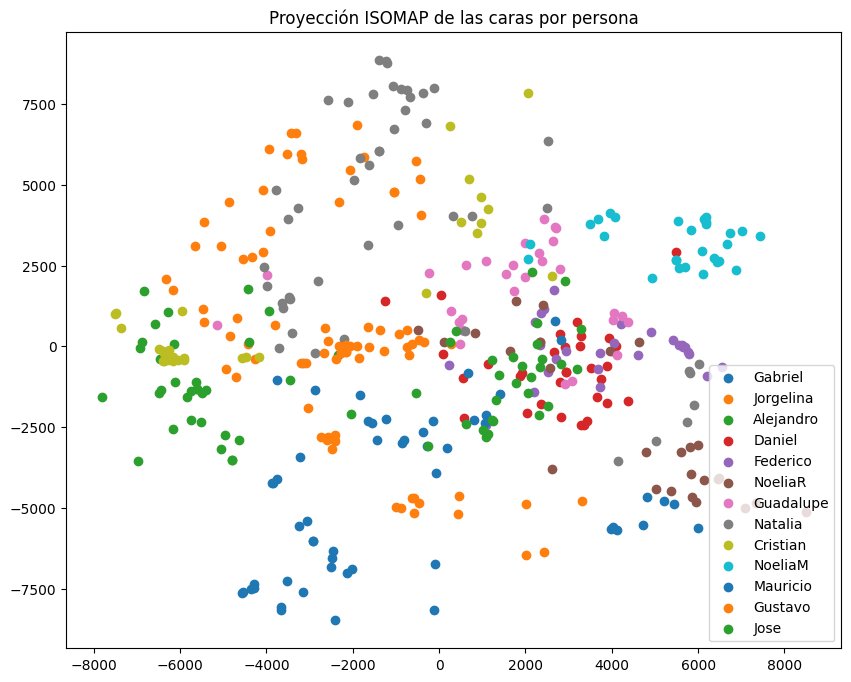

In [ ]:
plt.figure(figsize=(10, 8))
for etiqueta in set(y_train):
    idxs = [i for i, e in enumerate(y_train) if e == etiqueta]
    plt.scatter(X_train_iso[idxs, 0], X_train_iso[idxs, 1], label=etiqueta)

plt.legend()
plt.title("Proyección ISOMAP de las caras por persona")
plt.show()

## **Generamos dataframe train**

In [ ]:
# Generar nombres de componentes: x1, x2, ..., xN
column_names = [f"x{i+1}" for i in range(X_train_iso.shape[1])]
df_X_train = pl.DataFrame(X_train_iso, schema=column_names)

df_train = df_X_train.with_columns(pl.Series("y", y_train))

# Verificar
df_train.head()


shape: (5, 31)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ x1        ┆ x2        ┆ x3        ┆ x4        ┆ … ┆ x28       ┆ x29       ┆ x30       ┆ y        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 6212.9518 ┆ -910.5789 ┆ -564.1508 ┆ 2112.5240 ┆ … ┆ -109.2917 ┆ -172.6013 ┆ 513.61987 ┆ Federico │
│ 56        ┆ 21        ┆ 63        ┆ 24        ┆   ┆ 16        ┆ 3         ┆ 4         ┆          │
│ -4079.621 ┆ 4848.1566 ┆ 383.27619 ┆ 2031.9291 ┆ … ┆ -417.4774 ┆ 401.26722 ┆ -709.1535 ┆ Jorgelin │
│ 47        ┆ 76        ┆           ┆ 16        ┆   ┆ 73        ┆ 3         ┆ 49        ┆ a        │
│ 5845.1036 ┆ 3592.9298 ┆ -2714.944 ┆ 2485.5836 ┆ … ┆ -691.2601 ┆ -664.8030 ┆ 611.71865 ┆ NoeliaM  │
│ 89        ┆ 43        ┆ 026       ┆ 08        ┆   ┆ 98        ┆ 4         ┆ 4         ┆          │
│ -6578.487 ┆ 684.26557 ┆ -2608.610 ┆ -434.6496 ┆ … ┆ -2015.475 ┆ -497.3081 ┆ -214.2039 ┆ Alejandr │
│ 449       ┆ 2         ┆ 08        ┆ 57        ┆   ┆ 431       ┆ 8         ┆ 23        ┆ o        │
│ -4797.975 ┆ -3514.859 ┆ -2322.707 ┆ 502.63860 ┆ … ┆ 145.39142 ┆ 507.22352 ┆ 233.96700 ┆ Alejandr │
│ 214       ┆ 897       ┆ 781       ┆ 3         ┆   ┆ 4         ┆ 8         ┆ 9         ┆ o        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## **Generar dataframe test**

In [ ]:
# Generar nombres de componentes: x1, x2, ..., xN
column_names = [f"x{i+1}" for i in range(X_test_iso.shape[1])]
df_X_test = pl.DataFrame(X_test_iso, schema=column_names)

df_test = df_X_test.with_columns(pl.Series("y", y_test))

# Verificar
df_test.head()

shape: (5, 31)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ x1        ┆ x2        ┆ x3        ┆ x4        ┆ … ┆ x28       ┆ x29       ┆ x30       ┆ y        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -1254.445 ┆ 8896.7745 ┆ 1932.3061 ┆ 3509.6579 ┆ … ┆ -651.9974 ┆ 458.19066 ┆ 258.50034 ┆ Natalia  │
│ 355       ┆ 75        ┆ 72        ┆ 62        ┆   ┆ 1         ┆ 3         ┆ 9         ┆          │
│ -6747.182 ┆ 1670.2112 ┆ -5015.908 ┆ -1892.463 ┆ … ┆ 635.13103 ┆ 1055.0596 ┆ -1589.745 ┆ Alejandr │
│ 883       ┆ 99        ┆ 172       ┆ 712       ┆   ┆ 8         ┆ 81        ┆ 252       ┆ o        │
│ 81.573975 ┆ -77.22719 ┆ 1270.8136 ┆ -27.81199 ┆ … ┆ -118.3475 ┆ 153.47724 ┆ 804.43759 ┆ Jose     │
│           ┆ 7         ┆ 3         ┆ 1         ┆   ┆ 53        ┆ 1         ┆ 7         ┆          │
│ -931.7036 ┆ -4976.348 ┆ -1372.818 ┆ 2228.3019 ┆ … ┆ -690.5794 ┆ 434.80057 ┆ -372.1011 ┆ Jorgelin │
│ 22        ┆ 544       ┆ 665       ┆ 46        ┆   ┆ 9         ┆ 3         ┆ 99        ┆ a        │
│ -2345.371 ┆ -3394.089 ┆ -1231.649 ┆ 446.90669 ┆ … ┆ 656.41056 ┆ 668.27313 ┆ 628.86312 ┆ Gustavo  │
│ 022       ┆ 784       ┆ 059       ┆ 3         ┆   ┆ 8         ┆ 4         ┆ 9         ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
# Guardamos el dataframe de train .pkl
with open('/content/drive/MyDrive/DMA_Eigenfaces/isomap_train.pkl', 'wb') as f:
    pickle.dump(df_train, f)

# Guardamos el dataframe de test .pkl
with open('/content/drive/MyDrive/DMA_Eigenfaces/isomap_test.pkl', 'wb') as f:
    pickle.dump(df_test, f)


Modelo ISOMAP y datos transformados guardados con éxito.
Modelo ISOMAP y datos transformados guardados con éxito.
